In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

#Training algorithms import
import xgboost as xgb 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor



plt.style.use("fivethirtyeight")

# Evaluation and training imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

In [2]:
df = pd.read_csv("..\data\sensor_data.csv", parse_dates=True, header=None) #, index_col="Datetime"
df.columns = ["Datetime","Temperature", "Humidity" , "Pressure", "Altitude" ,"CO" ,"CO2" ,"NH4", "PM1.0" ,"PM2.5", "PM10.0"]
df['Datetime'] = pd.to_datetime(df["Datetime"], format='%Y-%m-%d %H:%M:%S')

quantities = ['Temperature', 'Rel. Humidity', 'Pressure', 'CO', r'CO$_2$', r'NH$_3$', r'PM$_{1}$', 
                  'PM$_{2.5}$', 'PM$_{10}$']
units = [r'$^o$C','%', 'hPa','ppm','ppm','ppm',r'$\mu g/m^3$ ',r'$\mu g/m^3$ ',r'$\mu g/m^3$ ']
df = df.set_index("Datetime")
df['Pressure'] = df['Pressure']/100

## For PM1.0

In [3]:
# Adding an hour feature to the dataset 
df["hour"] = df.index.hour

<AxesSubplot: title={'center': 'Particulate Matter 1.0 [$\\mu g/m^3$ ]'}, xlabel='Datetime'>

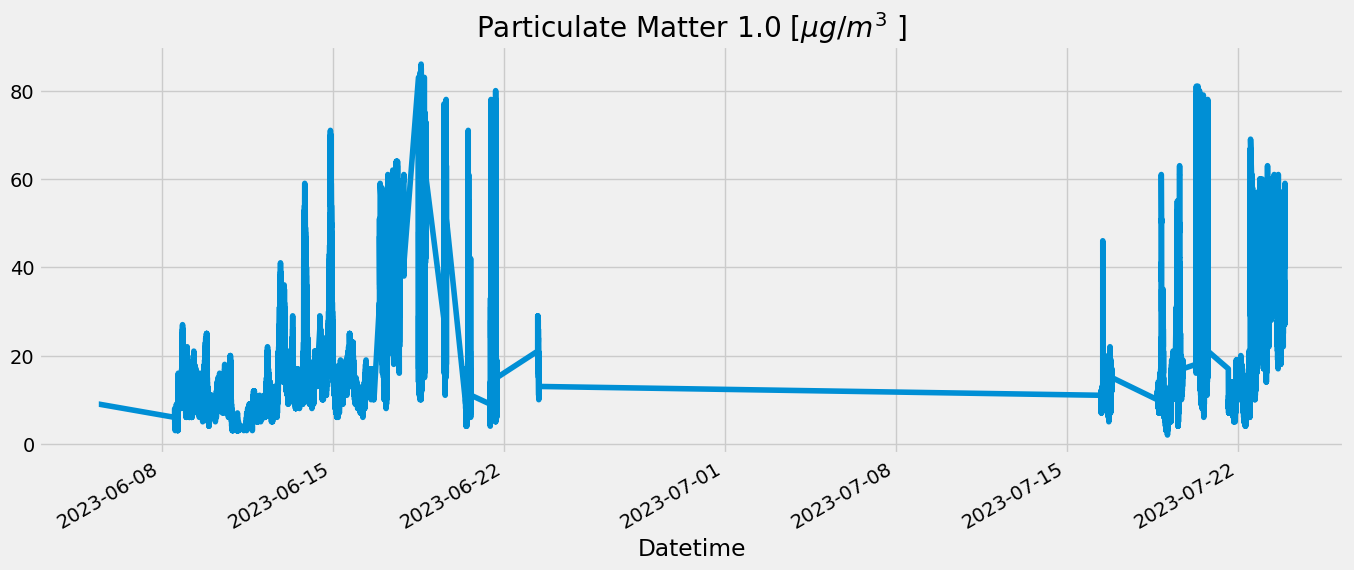

In [4]:
df["PM1.0"].plot(figsize=(15, 6), title=f"Particulate Matter 1.0 [{units[6]}]")

## Model Creation


### Train/ Test Split


In [5]:
#Splitting of train and test data
X = df.drop("PM1.0", axis=1)
y = df["PM1.0"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

## XGBoost Linear Regression

In [6]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
xgb_model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_test, y_test)],
             verbose=100)

[0]	validation_0-rmse:18.96712	validation_1-rmse:18.93883
[100]	validation_0-rmse:7.08448	validation_1-rmse:7.09986
[200]	validation_0-rmse:2.88663	validation_1-rmse:2.91789
[300]	validation_0-rmse:1.58824	validation_1-rmse:1.62231
[400]	validation_0-rmse:1.27894	validation_1-rmse:1.31149
[500]	validation_0-rmse:1.19391	validation_1-rmse:1.22673
[600]	validation_0-rmse:1.15378	validation_1-rmse:1.18837
[700]	validation_0-rmse:1.13347	validation_1-rmse:1.17342
[800]	validation_0-rmse:1.11496	validation_1-rmse:1.15652
[900]	validation_0-rmse:1.10216	validation_1-rmse:1.14567
[999]	validation_0-rmse:1.09164	validation_1-rmse:1.13780


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [7]:
pm1_0_model = joblib.dump(xgb_model, "new_trained/xgb_pm1.sav")

 ### Feature Importance

In [8]:
fi = pd.DataFrame(data=xgb_model.feature_importances_,
             index=xgb_model.feature_names_in_,
             columns=["importance"])

<AxesSubplot: title={'center': 'Feature Importance'}>

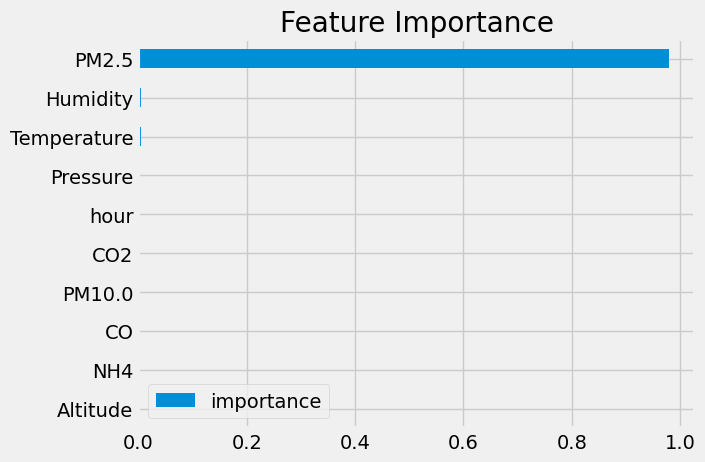

In [9]:
fi.sort_values('importance').plot(kind="barh", title="Feature Importance")

### Forecast on Test

In [10]:
# Forecasting previous values to see the performance of model
xgb_prediction = xgb_model.predict(X)
df["xgbpredict"] = xgb_prediction

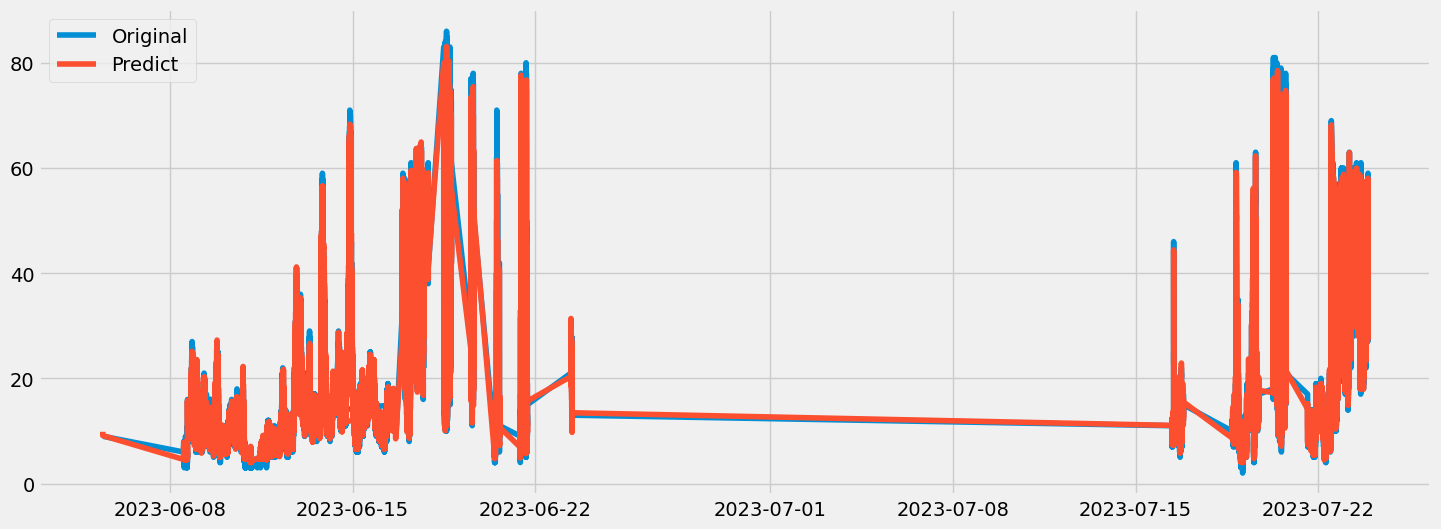

In [11]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM1.0"], label="Original")
ax.plot(df["xgbpredict"], label="Predict")


ax.legend()

### Evaluation Metric

In [12]:
#  Mean Squared Error
xgb_mse = mean_squared_error(df["PM1.0"], df["xgbpredict"])
xgb_mse

1.2071131473436154

In [13]:
#Root Mean Squared Error
xgb_rmse = np.sqrt(mean_squared_error(df["PM1.0"], df["xgbpredict"]))
xgb_rmse

1.0986870106375224

In [14]:
# Mean Absolute Error
xgb_mae = mean_absolute_error(df["PM1.0"], df["xgbpredict"])
xgb_mae

0.8176770361750924

In [15]:
xgb_err_eval = [xgb_mse, xgb_rmse, xgb_mae]
xgb_err_eval

[1.2071131473436154, 1.0986870106375224, 0.8176770361750924]

## Sklearn Linear Regression 

In [16]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)



LinearRegression()

In [17]:
linreg_model_sav = joblib.dump(linreg_model, "new_trained/linreg_pm1.sav")

### Forecast on Test

In [18]:
# Forecasting previous values to see the performance of model
linreg_prediction = linreg_model.predict(X)
df["linregpredict"] = linreg_prediction

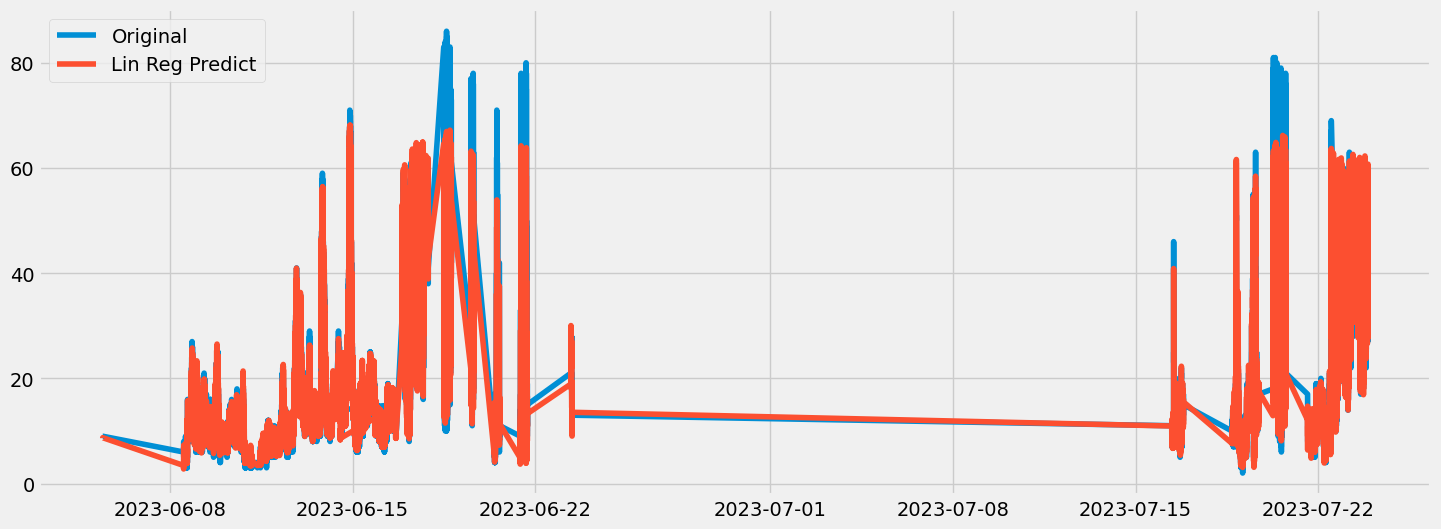

In [19]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM1.0"], label="Original")
ax.plot(df["linregpredict"], label="Lin Reg Predict")


ax.legend()

### Evaluation Metric

In [20]:
#  Mean Squared Error
linreg_mse = mean_squared_error(df["PM1.0"], df["linregpredict"])
linreg_mse

2.467263376124522

In [21]:
#Root Mean Squared Error
linreg_rmse = np.sqrt(mean_squared_error(df["PM1.0"], df["linregpredict"]))
linreg_rmse

1.5707524872253178

In [22]:
# Mean Absolute Error
linreg_mae = mean_absolute_error(df["PM1.0"], df["linregpredict"])
linreg_mae

1.0671940735303351

In [23]:
linreg_err_eval = [linreg_mse, linreg_rmse, linreg_mae]
linreg_err_eval

[2.467263376124522, 1.5707524872253178, 1.0671940735303351]

## Sklearn  Decision Tree Classifier

In [24]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)


DecisionTreeClassifier()

In [25]:
tree_model_sav = joblib.dump(tree_model, "new_trained/tree_pm1.sav")

### Forecast on Test

In [26]:
# Forecasting previous values to see the performance of model
tree_model_prediction = tree_model.predict(X)
df["treepredict"] = tree_model_prediction

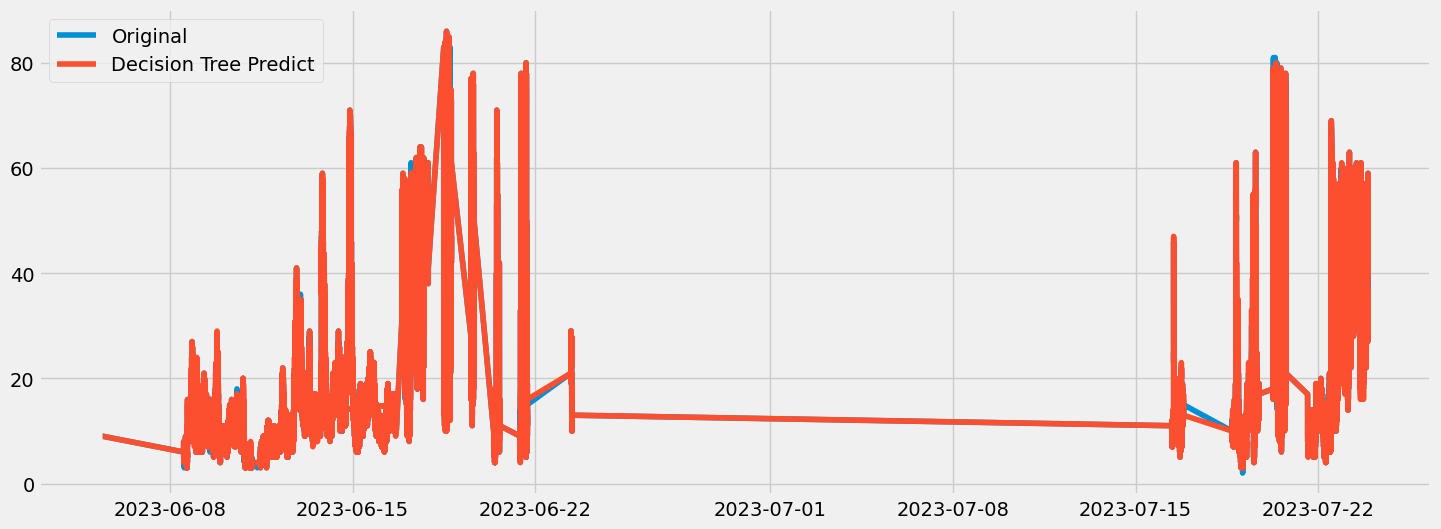

In [27]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM1.0"], label="Original")
ax.plot(df["treepredict"], label="Decision Tree Predict")


ax.legend()

### Evaluation Metric

In [28]:
#  Mean Squared Error
tree_model_mse = mean_squared_error(df["PM1.0"], df["treepredict"])
tree_model_mse

0.31850154903483213

In [29]:
#Root Mean Squared Error
tree_model_rmse = np.sqrt(mean_squared_error(df["PM1.0"], df["treepredict"]))
tree_model_rmse

0.5643594147658317

In [30]:
# Mean Absolute Error
tree_model_mae = mean_absolute_error(df["PM1.0"], df["treepredict"])
tree_model_mae

0.1207017166227197

In [31]:
tree_err_eval = [tree_model_mse, tree_model_rmse, tree_model_mae]
tree_err_eval

[0.31850154903483213, 0.5643594147658317, 0.1207017166227197]

## Sklearn  Decision Tree Regressor

In [32]:
tree_reg_model = DecisionTreeRegressor()
tree_reg_model.fit(X_train, y_train)



DecisionTreeRegressor()

In [33]:
tree_reg_model_sav = joblib.dump(tree_model, "new_trained/tree_reg_pm1.sav")

### Forecast on Test

In [34]:
# Forecasting previous values to see the performance of model
tree_reg_prediction = tree_reg_model.predict(X)
df["tree_reg_predict"] = tree_reg_prediction

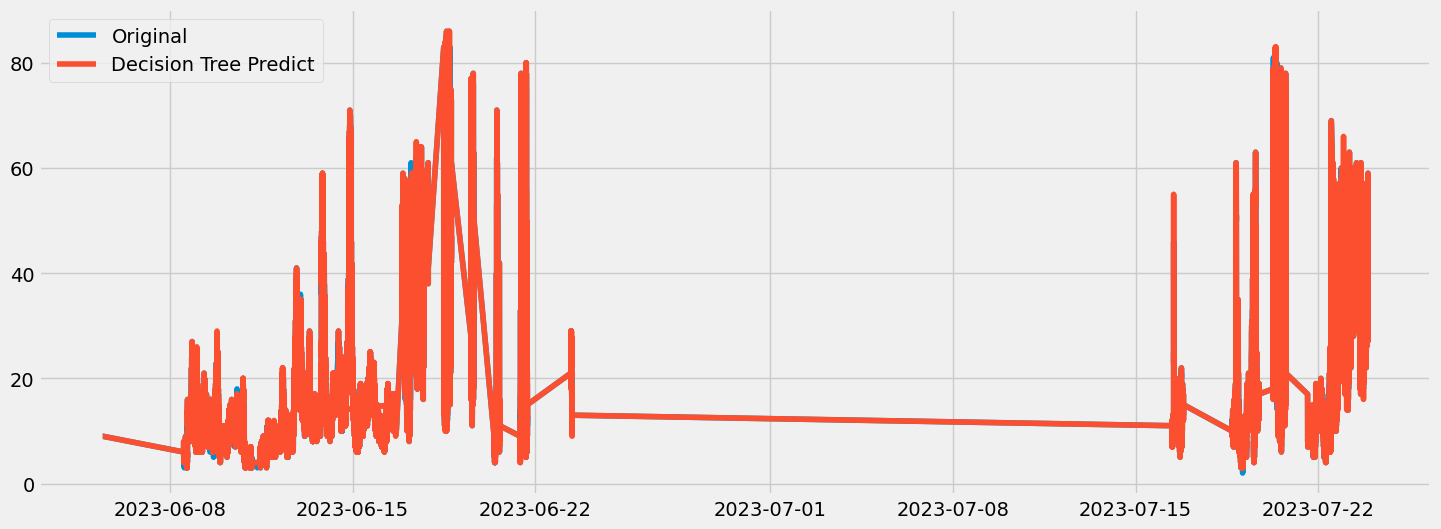

In [35]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM1.0"], label="Original")
ax.plot(df["tree_reg_predict"], label="Decision Tree Predict")


ax.legend()

### Evaluation Metric

In [36]:
#  Mean Squared Error
tree_reg_model_mse = mean_squared_error(df["PM1.0"], df["tree_reg_predict"])
tree_reg_model_mse

0.2694244355440072

In [37]:
#Root Mean Squared Error
tree_reg_model_rmse = np.sqrt(mean_squared_error(df["PM1.0"], df["tree_reg_predict"]))
tree_reg_model_rmse

0.519061109643178

In [38]:
# Mean Absolute Error
tree_reg_model_mae = mean_absolute_error(df["PM1.0"], df["tree_reg_predict"])
tree_reg_model_mae

0.11644283177404847

In [39]:
tree_reg_err_eval = [tree_reg_model_mse, tree_reg_model_rmse, tree_reg_model_mae]
tree_reg_err_eval

[0.2694244355440072, 0.519061109643178, 0.11644283177404847]

## Sklearn RandomForest Classifier

In [40]:
rforest_model = RandomForestClassifier()
rforest_model.fit(X_train, y_train)



RandomForestClassifier()

In [41]:
rforest_model_sav = joblib.dump(rforest_model, "new_trained/rforest_pm1.sav")

### Forecast on Test

In [42]:
# Forecasting previous values to see the performance of model
rforest_prediction = rforest_model.predict(X)
df["rforestpredict"] = rforest_prediction

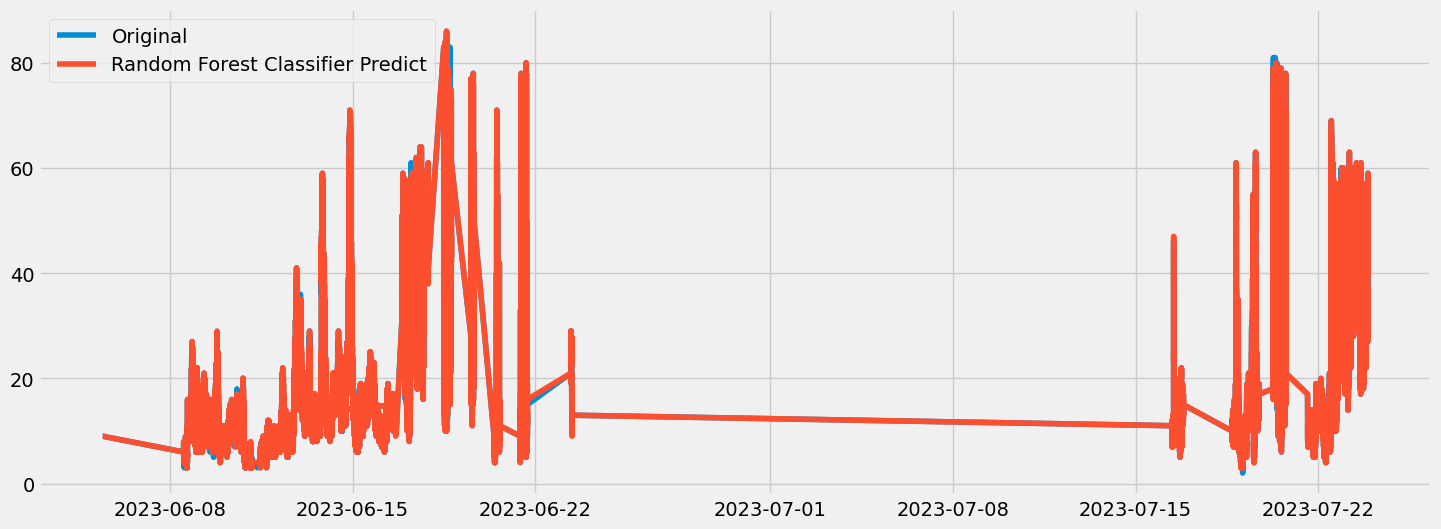

In [43]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM1.0"], label="Original")
ax.plot(df["rforestpredict"], label="Random Forest Classifier Predict")


ax.legend()

### Evaluation Metric

In [44]:
#  Mean Squared Error
rforest_mse = mean_squared_error(df["PM1.0"], df["rforestpredict"])
rforest_mse

0.22218463880197722

In [45]:
#Root Mean Squared Error
rforest_rmse = np.sqrt(mean_squared_error(df["PM1.0"], df["rforestpredict"]))
rforest_rmse

0.4713646558684446

In [46]:
# Mean Absolute Error
rforest_mae = mean_absolute_error(df["PM1.0"], df["rforestpredict"])
rforest_mae

0.09869235322606683

In [47]:
rforest_err_eval = [rforest_mse, rforest_rmse, rforest_mae]
rforest_err_eval

[0.22218463880197722, 0.4713646558684446, 0.09869235322606683]

## Sklearn RandomForest Regressor

In [48]:
rforest_reg_model = RandomForestRegressor()
rforest_reg_model.fit(X_train, y_train)



RandomForestRegressor()

In [49]:
rforest_reg_model_sav = joblib.dump(rforest_reg_model, "new_trained/rforest_reg_pm1.sav")

### Forecast on Test

In [50]:
# Forecasting previous values to see the performance of model
rforest_reg_prediction = rforest_model.predict(X)
df["rforest_reg_predict"] = rforest_reg_prediction

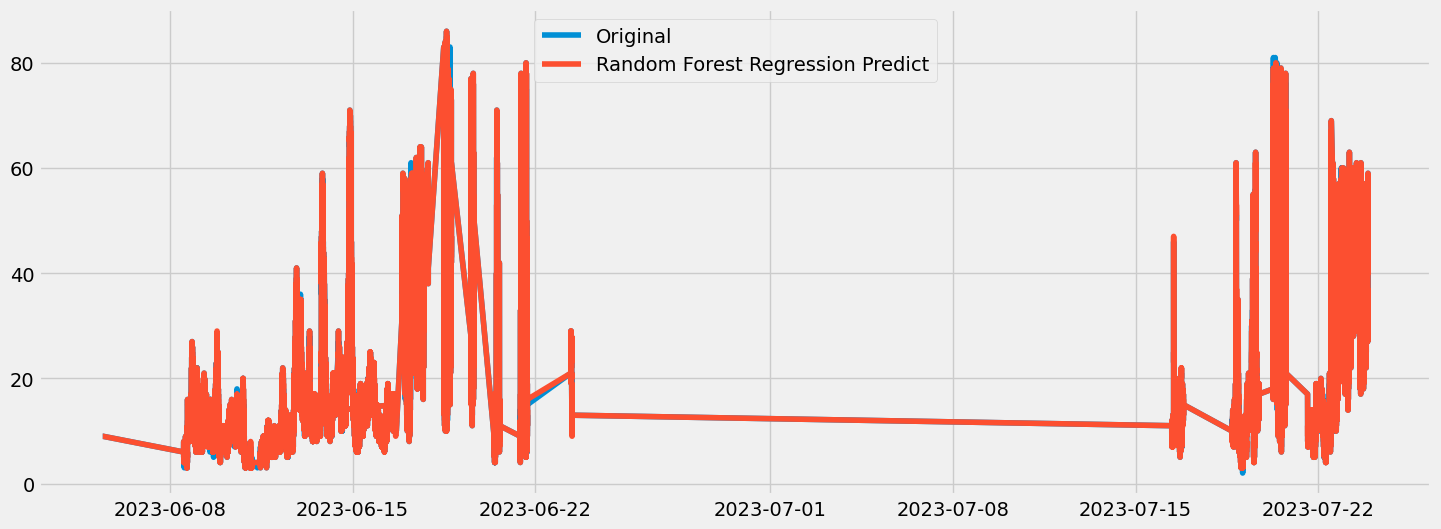

In [51]:
# A plot of predicted and orignal values
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df["PM1.0"], label="Original")
ax.plot(df["rforest_reg_predict"], label="Random Forest Regression Predict")


ax.legend()

### Evaluation Metric

In [52]:
#  Mean Squared Error
rforest_reg_mse = mean_squared_error(df["PM1.0"], df["rforest_reg_predict"])
rforest_reg_mse

0.22218463880197722

In [53]:
#Root Mean Squared Error
rforest_reg_rmse = np.sqrt(mean_squared_error(df["PM1.0"], df["rforest_reg_predict"]))
rforest_reg_rmse

0.4713646558684446

In [54]:
# Mean Absolute Error
rforest_reg_mae = mean_absolute_error(df["PM1.0"], df["rforest_reg_predict"])
rforest_reg_mae

0.09869235322606683

In [55]:
rforest_reg_err_eval = [rforest_reg_mse, rforest_reg_rmse, rforest_reg_mae]
rforest_reg_err_eval

[0.22218463880197722, 0.4713646558684446, 0.09869235322606683]

## Overall Minimum Error Evaluation of Models

In [56]:
# error_evals = [xgb_err_eval,
#                 linreg_err_eval,
#                 tree_err_eval,
#                 tree_reg_err_eval,
#                 rforest_err_eval,
#                 rforest_reg_err_eval]


error_evals = {"Xgb Reg": xgb_err_eval,
            "Linear Reg": linreg_err_eval,
            "DecisionTreeClassifier": tree_err_eval,
            "DecisionTreeRegressor": tree_reg_err_eval,
            "RandomForestClassifier": rforest_err_eval,
            "RandomForestRegressor": rforest_reg_err_eval}

error_evals

{'Xgb Reg': [1.2071131473436154, 1.0986870106375224, 0.8176770361750924],
 'Linear Reg': [2.467263376124522, 1.5707524872253178, 1.0671940735303351],
 'DecisionTreeClassifier': [0.31850154903483213,
  0.5643594147658317,
  0.1207017166227197],
 'DecisionTreeRegressor': [0.2694244355440072,
  0.519061109643178,
  0.11644283177404847],
 'RandomForestClassifier': [0.22218463880197722,
  0.4713646558684446,
  0.09869235322606683],
 'RandomForestRegressor': [0.22218463880197722,
  0.4713646558684446,
  0.09869235322606683]}

In [57]:
# Finding the lowest error evaluations for trained models
def comp_val(sublist):
    return sublist[0]

min_error = min(error_evals, key=lambda key: comp_val(error_evals[key]))
print(f"Lowest error evaluation for trained models was {min_error}")

Lowest error evaluation for trained models was RandomForestClassifier


In [59]:
df.describe()

,Temperature,Humidity,Pressure,Altitude,CO,CO2,NH4,PM1.0,PM2.5,PM10.0,hour,xgbpredict,linregpredict,treepredict,tree_reg_predict,rforestpredict,rforest_reg_predict
count,130081.000000,130081.000000,130081.000000,130081.000000,130081.000000,130081.000000,130081.000000,130081.000000,130081.000000,130081.000000,130081.000000,130081.000000,130081.000000,130081.000000,130081.000000,130081.000000,130081.000000
mean,28.177515,53.251829,984.943335,238.393727,1.811643,401.530601,2.491089,16.611158,24.815008,25.789008,11.838662,16.608574,16.608849,16.608721,16.608721,16.608298,16.608298
std,2.184615,12.482415,1.695714,14.443661,1.572236,0.894979,1.228810,10.356710,16.618367,17.469146,6.607229,10.272099,10.232479,10.351426,10.357547,10.342381,10.342381
min,21.720000,27.320000,980.658600,201.030000,0.190000,400.310000,0.640000,2.000000,5.000000,7.000000,0.000000,3.998248,2.770276,3.000000,3.000000,3.000000,3.000000
25%,26.930000,45.440000,983.707900,227.620000,0.850000,400.930000,1.650000,10.000000,14.000000,15.000000,6.000000,9.879610,10.060875,10.000000,10.000000,10.000000,10.000000
50%,27.550000,48.790000,984.845400,239.220000,1.220000,401.210000,2.070000,13.000000,20.000000,20.000000,12.000000,13.420248,13.421137,13.000000,13.000000,13.000000,13.000000
75%,29.220000,60.470000,986.208000,248.910000,2.370000,401.970000,3.150000,19.000000,28.000000,29.000000,17.000000,19.040306,18.863121,19.000000,19.000000,19.000000,19.000000
max,44.440000,86.950000,989.335900,274.950000,32.240000,413.110000,16.200000,86.000000,105.000000,107.000000,23.000000,83.096733,68.144496,86.000000,86.000000,86.000000,86.000000
